<span style="color:blue">

We would like to create Question-Answering system in the biomedical domain using public data using RH LLMaaS on local system.

For this, we shall create a RAG application using granite-3.1 model (offered by RH LLMaaS). We shall feed the documents in it. After the RAG pipeline is ready, we shall use the questions to get responses from the RAG pipeline and compare them with the ground truth answers.

So the steps are as follows:

1. Download and explore a public dataset
2. Ingest the documents into a vectordb/documentstore
3. Design the RAG pipeline using the vectordb/documentstore and an LLM (granite-3.1)
4. Ask questions to the RAG application and compare response with ground truth answers.

</span>

# <span style="color:red">1. Download and explore a public dataset </span>

## 1.1 Download PubMed dataset

<span style="color:blue">
    
We are going to use huggingface library `datasets` (`https://github.com/huggingface/datasets`) to get some public dataset from huggingface for the experimentation

Here we are going to use https://huggingface.co/datasets/vblagoje/PubMedQA_instruction . `PubMedQA_instruction` refers to a dataset designed for training and evaluating models on question-answering (QA) tasks in the biomedical domain.

So lets download the `vblagoje/PubMedQA_instruction` dataset 

</span>

In [1]:
from datasets import load_dataset

# Point to the huggingface dataset id 'vblagoje/PubMedQA_instruction'
dataset = load_dataset(path="vblagoje/PubMedQA_instruction", split="train")
dataset.shape

(272458, 4)

## 1.2 Select the right sample size

<span style="color:blue">
It has total 272458 examples. It's quite huge. Lets downsample and select 250 of them for the experiment.
</span>

In [2]:
dataset = dataset.select(range(250))

## 1.3 Explore the dataset

<span style="color:blue">
    
We need to explore the dataset first. Let's look at the first record. Each record contains 3 main fields - `instruction`, `context` and `response`. Essentially, for a given `context/document` there is a `response/answer` for the asked `instruction/question`

</span>

In [3]:
dataset[:1]

{'instruction': ['Are group 2 innate lymphoid cells ( ILC2s ) increased in chronic rhinosinusitis with nasal polyps or eosinophilia?'],
 'context': ['Chronic rhinosinusitis (CRS) is a heterogeneous disease with an uncertain pathogenesis. Group 2 innate lymphoid cells (ILC2s) represent a recently discovered cell population which has been implicated in driving Th2 inflammation in CRS; however, their relationship with clinical disease characteristics has yet to be investigated. The aim of this study was to identify ILC2s in sinus mucosa in patients with CRS and controls and compare ILC2s across characteristics of disease. A cross-sectional study of patients with CRS undergoing endoscopic sinus surgery was conducted. Sinus mucosal biopsies were obtained during surgery and control tissue from patients undergoing pituitary tumour resection through transphenoidal approach. ILC2s were identified as CD45(+) Lin(-) CD127(+) CD4(-) CD8(-) CRTH2(CD294)(+) CD161(+) cells in single cell suspensions 

<span style="color:blue">

Great!! We are done with the 1st step of our goal.

</span>   

# <span style="color:red"> 2. Ingest documents into vectordb/documentstore </span>

## 2.1 Prepare the documents

<span style="color:blue">
    
Lets segregate `instruction/question`, `context/document` and `response/answer` in separate python objects.

</span>

In [4]:
from haystack import Document

all_documents = [Document(content=doc["context"]) for doc in dataset]
all_questions = [doc["instruction"] for doc in dataset]
all_ground_truth_answers = [doc["response"] for doc in dataset]

## 2.2 Select a vectordb for storing the document embeddings

<span style="color:blue">

haystack comes with in-memory documentstore `InMemoryDocumentStore` which can be used as an alternative to vectordb. The `InMemoryDocumentStore` in Haystack is a lightweight, in-memory document store primarily used for testing, prototyping, or small-scale applications. It stores documents in Python dictionaries, making it fast but not persistent (data is lost when the program stops). https://docs.haystack.deepset.ai/docs/inmemorydocumentstore 

</span>


In [5]:
from haystack.document_stores.in_memory import InMemoryDocumentStore
# Use your preferred vectordb
document_store = InMemoryDocumentStore(embedding_similarity_function="cosine")

## 2.3 Design the Ingestion/Indexing pipeline

<span style="color:blue">

In this step we use the embedding model `mixedbread-ai/mxbai-embed-large-v1` to convert the documents into embedding and store those embeddings along with the respective documents into the documentstore. https://huggingface.co/mixedbread-ai/mxbai-embed-large-v1

</span>

In [6]:
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack.components.writers import DocumentWriter
from haystack.document_stores.types import DuplicatePolicy
from haystack import Pipeline

# Use your preferred embedding model approved by RH legal
document_embedder = SentenceTransformersDocumentEmbedder(model="mixedbread-ai/mxbai-embed-large-v1")
document_writer = DocumentWriter(document_store=document_store, policy=DuplicatePolicy.SKIP)

indexing = Pipeline()
indexing.add_component(name="document_embedder", instance=document_embedder)
indexing.add_component(name="document_writer", instance=document_writer)

# Connect the components in the pipeline
indexing.connect("document_embedder.documents", "document_writer.documents")


🚅 Components
  - document_embedder: SentenceTransformersDocumentEmbedder
  - document_writer: DocumentWriter
🛤️ Connections
  - document_embedder.documents -> document_writer.documents (List[Document])

## 2.4 Visualize the indexing pipeline

<span style="color:blue">

Lets take a moment to see the different stateges of the pipeline that we created.

</span>

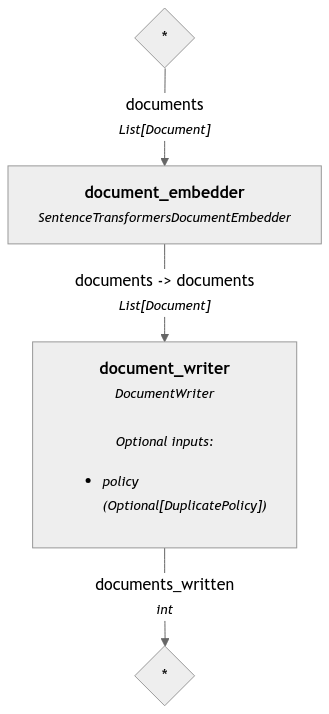

In [7]:
indexing.show()

## 2.5 Ingest the documents into the documentstore

<span style="color:blue">

Run the indexing pipeline and ingest the documents in the in-memory documentstore

</span>

In [8]:
from typing import List

indexing.run({"document_embedder": {"documents": all_documents}})

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

{'document_writer': {'documents_written': 250}}

<span style="color:blue">

Great!! We are done with the 2nd step of our goal.

</span>

# <span style="color:red"> 3. Create RAG Pipeline </span>

## 3.1 Set Openai credentials 

In [9]:
import os

if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = "your-openai-key"


if "OPENAI_MODEL_ID" not in os.environ:
    os.environ["OPENAI_MODEL_ID"] = "gpt-4o-mini"

## 3.2 Design the RAG pipeline

<span style="color:blue">

Lets create the RAG pipeline using the same embedding model `mixedbread-ai/mxbai-embed-large-v1` and the LLMaaS model `granite-3.1-8b-instruct`

</span>

In [10]:
from haystack.components.embedders import SentenceTransformersTextEmbedder
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.dataclasses import ChatMessage
from haystack.components.builders import ChatPromptBuilder,AnswerBuilder
from haystack.components.generators.chat import OpenAIChatGenerator
from haystack.utils import Secret


rag_pipeline = Pipeline()

# 1st component -  query_embedder
# Unlike the DocumentEmbedder during the document ingestion, this time we shall use TextEmbedder, 
# but with the same embedding model `mixedbread-ai/mxbai-embed-large-v1`
rag_pipeline.add_component(name="query_embedder", instance=SentenceTransformersTextEmbedder(model="mixedbread-ai/mxbai-embed-large-v1")
)

# 2nd compoment - retriever 
# This constitutes the "R" of "RAG". It "R"etrieves the top 3 documents from the documentstore 
# based on the cosine similarity with the query embedding from the previous component
rag_pipeline.add_component(name="retriever", instance=InMemoryEmbeddingRetriever(document_store, top_k=3))

# 3rd compoment - prompt_builder
# This constitutes the "A" of "RAG". It "A"ugments the query and the retrieved document into the chat template 
# to build the prompt
template = [
    ChatMessage.from_user(
        """
        You have to answer the following question based on the given context information only.

        Context:
        {% for document in documents %}
            {{ document.content }}
        {% endfor %}

        Question: {{question}}
        Answer:
        """
    )
]
rag_pipeline.add_component("prompt_builder", ChatPromptBuilder(template=template))

# 4th compoment - generator
# This constitutes the "G" of "RAG". It "G"enerates the answer using the LLMaaS 
# The LLMaaS credentials are passed here
rag_pipeline.add_component("generator", OpenAIChatGenerator(
    api_key=Secret.from_token(os.environ["OPENAI_API_KEY"]),
    model=os.environ["OPENAI_MODEL_ID"],
    generation_kwargs = {"max_tokens": 512}
))

# 5th and the final compoment - answer_builder
# Takes a query, retrieved documents and the replies from the Generator as input and parses them into GeneratedAnswer objects
rag_pipeline.add_component("answer_builder", AnswerBuilder())

# Now lets connext the components
rag_pipeline.connect("query_embedder", "retriever.query_embedding")
rag_pipeline.connect("retriever", "prompt_builder.documents")
rag_pipeline.connect("prompt_builder.prompt", "generator.messages")
rag_pipeline.connect("generator.replies", "answer_builder.replies")
rag_pipeline.connect("retriever", "answer_builder.documents")


🚅 Components
  - query_embedder: SentenceTransformersTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt_builder: ChatPromptBuilder
  - generator: OpenAIChatGenerator
  - answer_builder: AnswerBuilder
🛤️ Connections
  - query_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - retriever.documents -> answer_builder.documents (List[Document])
  - prompt_builder.prompt -> generator.messages (List[ChatMessage])
  - generator.replies -> answer_builder.replies (List[ChatMessage])

## 3.3 Show the RAG pipeline

<span style="color:blue">

Lets understand different stateges of the RAG pipeline that we created.

</span>

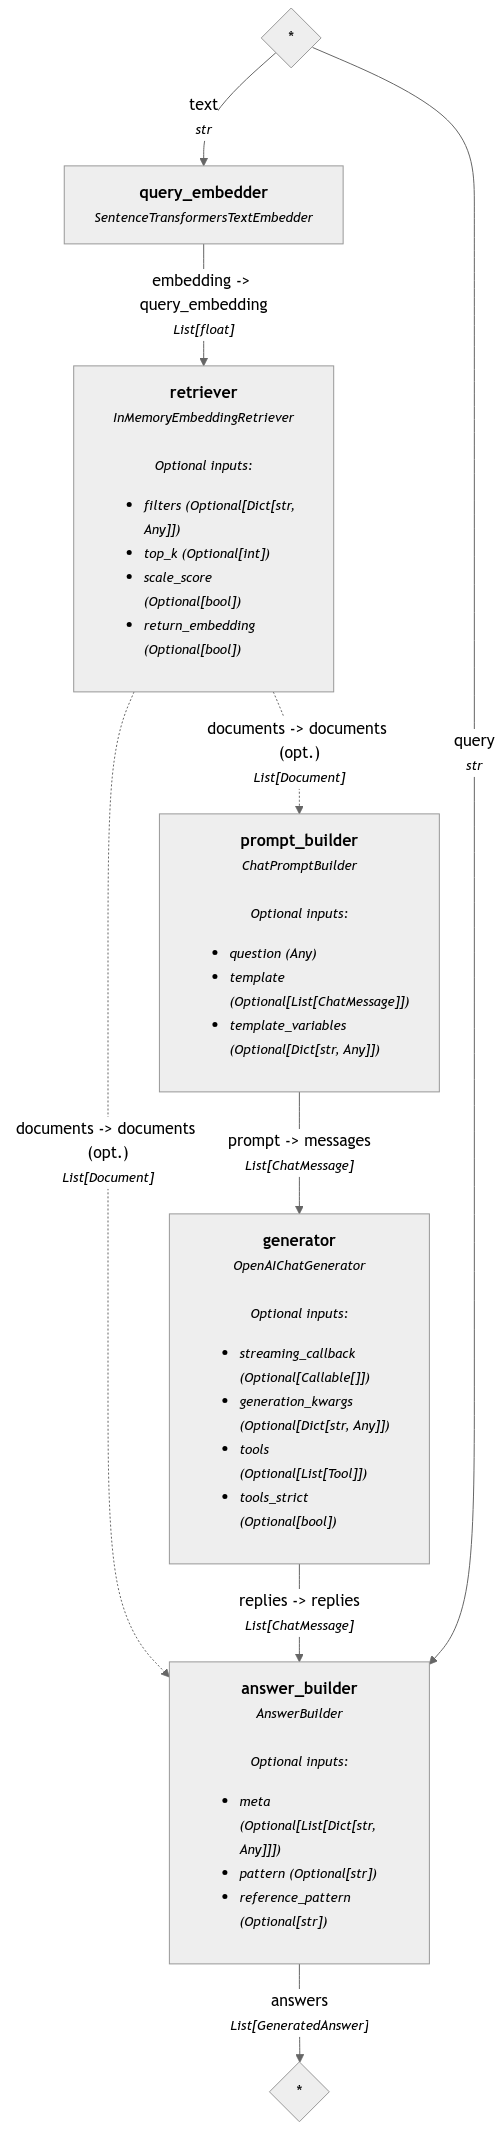

In [11]:
rag_pipeline.show()

<span style="color:blue">

So now we have setup the RAG pipeline.

</span>

# <span style="color:red"> 4. Ask questions to RAG pipeline</span>

<span style="color:blue">

Lets ask the RAG pipeline with a question from the dataset and compare with the corresponding ground truth answer

</span>

In [12]:
idx = 4

question = all_questions[idx]
ground_truth_answer = all_ground_truth_answers[idx]

response = rag_pipeline.run(
    {
        "query_embedder": {"text": question},
        "prompt_builder": {"question": question},
        "answer_builder": {"query": question},
    }
)
rag_answer = response["answer_builder"]["answers"][0].data

print("####################################")
print("QUESTION : ")
print("####################################\n")
print(question)
print("\n####################################")
print("RAG ANSWER : ")
print("####################################\n")
print(rag_answer)
print("\n####################################")
print("GROUND TRUTH ANSWER : ")
print("####################################\n")
print(ground_truth_answer)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

####################################
QUESTION : 
####################################

Do tumor-infiltrating immune cell profiles and their change after neoadjuvant chemotherapy predict response and prognosis of breast cancer?

####################################
RAG ANSWER : 
####################################

Yes, tumor-infiltrating immune cell profiles and their changes after neoadjuvant chemotherapy do predict response and prognosis of breast cancer. The study identified three immune cell profiles that correlated with pathological complete response (pCR) to neoadjuvant chemotherapy, with a higher infiltration of CD4 lymphocytes being the main factor associated with pCR. Additionally, changes in lymphocytic infiltration, including an inversion of the CD4/CD8 ratio after chemotherapy, were linked to better prognosis. Furthermore, a profile of residual tumor characterized by high CD3 and CD68 infiltration was associated with worse disease-free survival.

##########################